In [6]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
import math
import os
import tempfile
import matplotlib as mpl
from sklearn.metrics import confusion_matrix



In [7]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [8]:
#Karpathy 1. fix random seed
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)

In [9]:
ATT_FILE_NAME = "FootballPlayerPreparedCleanAttributes.csv"
ONE_HOT_ENCODED_CLASSES_FILE_NAME = "FootballPlayerOneHotEncodedClasses.csv"

In [10]:
att = pd.read_csv(ATT_FILE_NAME)
target = pd.read_csv(ONE_HOT_ENCODED_CLASSES_FILE_NAME)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
att.describe()

,Crossing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Reactions,ShotPower,Stamina,LongShots,Aggression,Positioning,Vision,Composure
count,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000
mean,0.053537,0.064942,0.168294,-0.081373,0.122654,-0.030012,-0.132537,0.002751,0.076091,0.098800,0.125965,0.169170,-0.025506,0.136145,0.043417,0.060219,0.036497
std,0.344606,0.293820,0.268085,0.369549,0.301492,0.364944,0.358826,0.334822,0.282066,0.233806,0.326638,0.324097,0.379027,0.352347,0.349409,0.314939,0.274291
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.195122,-0.139241,0.013699,-0.375000,-0.012048,-0.325301,-0.428571,-0.189189,-0.070423,-0.066667,-0.086420,-0.014493,-0.301205,-0.097561,-0.166667,-0.146341,-0.162162
50%,0.097561,0.088608,0.205479,-0.075000,0.180723,-0.012048,-0.190476,0.054054,0.098592,0.093333,0.160494,0.188406,0.036145,0.170732,0.095238,0.097561,0.054054
75%,0.317073,0.265823,0.342466,0.200000,0.325301,0.253012,0.142857,0.243243,0.267606,0.253333,0.358025,0.391304,0.277108,0.390244,0.285714,0.292683,0.243243
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
target.head()

,"Poor:[46.0, 62.0]","Interm:[63.0, 66.0]","Good:[67.0, 71.0]","Excel:[72.0, 94.0]"
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0


In [14]:
clases = np.argmax(target.to_numpy(),axis=1)

In [15]:
np.bincount(clases) # contar cuantos elemntos tengo de cada clase en el conjunto de datos

array([4296, 3868, 4353, 3605], dtype=int64)

In [16]:
c1, c2,c3,c4= np.bincount(clases)
total = c1+c2+c3+c4
print(f"Total: {total}. C1 {c1}, c2 {c2}, c3 {c3}, c4 {c4}") #lo mismo de arriba

Total: 16122. C1 4296, c2 3868, c3 4353, c4 3605


In [17]:
X_train,X_rem,y_train,y_rem = train_test_split(att,target,train_size=0.8)
X_valid,X_test,y_valid,y_test = train_test_split(X_rem,y_rem,train_size=0.5)
#80 % train   --- 10% val 10% test

In [18]:
c1, c2,c3,c4= np.bincount(np.argmax(y_train.to_numpy(),axis=1))
total = c1+c2+c3+c4
print(f"Total: {total}. C1 {c1}, c2 {c2}, c3 {c3}, c4 {c4}")

Total: 12897. C1 3455, c2 3086, c3 3479, c4 2877


In [19]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias) # inicializar el bias de la ultima capa de manera sesgada para que todas las clases sean "casi" iguales
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(17,)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(4, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 256

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

In [ ]:
-math.log(1/4)

In [ ]:
results = model.evaluate(X_train,y_train,batch_size=BATCH_SIZE)
print(f"Loss: {results[0]}")

In [ ]:
frequency = [c1/total,c2/total,c3/total,c4/total]
frequency


In [ ]:
bi = np.log(frequency)
bi

In [ ]:
from scipy.optimize import fsolve
from math import exp
def eqn(x, frequency=frequency):
  sum_exp = sum([exp(x_i) for x_i in x])
  return [exp(x[i])/sum_exp - frequency[i] for i in range(len(frequency))]

# calculate bias init
bias_init = fsolve(func=eqn,
                  x0=[0]*len(frequency),
                  ).tolist()

bias_init 

In [ ]:
model = make_model(output_bias=bias_init)
model.evaluate(X_train,y_train,batch_size=BATCH_SIZE)

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0,0.0,0.0,0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_test, y_test), 
    verbose=1)

In [ ]:
model = make_model(output_bias=bias_init)
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_test, y_test), 
    verbose=1)

In [26]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [27]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

NameError: name 'zero_bias_history' is not defined

In [24]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [25]:
plot_metrics(careful_bias_history)


NameError: name 'careful_bias_history' is not defined

In [28]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

NameError: name 'BATCH_SIZE' is not defined

In [22]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels,predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


In [ ]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(np.argmax(y_test.to_numpy(),axis=1), test_predictions_baseline.argmax(axis=1))

Generación de un modelo simple con un perceptron de una capa y pocas neuronas para conocer un poco donde estamos.

Utilizando 1 capa y pocas neuronas

Utilizando dos capas

Observamos que a mas capas, mejores resultados. Verificación utilizando muchas neuronas por capa

Resultados mejores. Probamos con aún más neuronas.

Añadir más neuronas auemnta el tiempo de entrenamiento ligeramente (CPU only) sin dar mejores resultados

El objetivo ahora es conseguir un modelo lo bastante grande que haga overfit a los datos y reducirlo

Como la precisión no parece estancarse lo dejamos durante muchas mas epocas

Observamos el overfit del modelo

In [ ]:
plt.plot(h_100x4x100.history['val_categorical_accuracy'])
plt.plot(h_100x4x100.history['categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_accuracy','train_accuracy'], loc='upper left')
plt.show()
# "Loss"

Aplicamos estrategias de regularización.

In [ ]:
model = model = keras.Sequential([
    keras.layers.Flatten(input_shape=(17,)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),





    keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()
h_100x4x100= model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test))

Tiene buana pinta

In [ ]:
model = model = keras.Sequential([
    keras.layers.Flatten(input_shape=(17,)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),





    keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()
h_100x4x100= model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test))

Añadir una capa mas no aporta nada

In [ ]:
model = model = keras.Sequential([
    keras.layers.Flatten(input_shape=(17,)),
    
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.25),

    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.25),

    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.25),
    





    keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()
h_100x4x100= model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test))

In [ ]:
plt.plot(h_128128.history['val_categorical_accuracy'])
plt.plot(h_nocapas.history['val_categorical_accuracy'])
plt.plot(h_512512.history['val_categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['h28128', 'nocapas','512512'], loc='upper left')
plt.show()
# "Loss"


In [20]:
def build_model(n_hidden=1, n_neurons_ocultas=[30], learning_rate=3e-3, input_shape=(8,), 
                activation_o="relu", optimizer="adam", loss="categorical_crossentropy", metrics=METRICS, 
                activation_s="soft_max", n_neurons_salida=4):     
    model = keras.models.Sequential()     
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    if n_hidden != len(n_neurons_ocultas):
        print("error, tamaño de la lista de n_neuronas no corresponde al umero de capas")
        return -1
    for layer in range(n_hidden):         
        model.add(keras.layers.Dense(n_neurons_ocultas[layer], activation="relu"))     
  
    model.add(keras.layers.Dense(n_neurons_salida, activation=activation_s))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)     
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)    
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 30)                540       
                                                                 
 dense_7 (Dense)             (None, 20)                620       
                                                                 
 dense_8 (Dense)             (None, 4)                 84        
                                                                 
Total params: 1,244
Trainable params: 1,244
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
51/51 [==============================] - 2s 14ms/step - loss: 0.9000 - tp: 5812.0000 - fp: 1750.0000 - tn: 41780.0000 - fn: 8698.0000 - accuracy: 0.8200 - precision: 0.7686 - recall: 0.4006 - auc: 0.8725 - prc: 0.7106 - val_loss: 0.7576 - val_tp: 906.0000 - val_fp: 407.0000 - val_tn: 4432.0000 - val_fn:

51/51 [==============================] - 0s 2ms/step - loss: 0.4510 - tp: 10282.0000 - fp: 2510.0000 - tn: 36181.0000 - fn: 2615.0000 - accuracy: 0.9007 - precision: 0.8038 - recall: 0.7972 - auc: 0.9606 - prc: 0.8921 - val_loss: 0.4872 - val_tp: 1263.0000 - val_fp: 339.0000 - val_tn: 4500.0000 - val_fn: 350.0000 - val_accuracy: 0.8932 - val_precision: 0.7884 - val_recall: 0.7830 - val_auc: 0.9544 - val_prc: 0.8743
Epoch 19/100
51/51 [==============================] - 0s 3ms/step - loss: 0.4493 - tp: 10309.0000 - fp: 2495.0000 - tn: 36196.0000 - fn: 2588.0000 - accuracy: 0.9015 - precision: 0.8051 - recall: 0.7993 - auc: 0.9610 - prc: 0.8929 - val_loss: 0.6805 - val_tp: 1088.0000 - val_fp: 499.0000 - val_tn: 4340.0000 - val_fn: 525.0000 - val_accuracy: 0.8413 - val_precision: 0.6856 - val_recall: 0.6745 - val_auc: 0.9230 - val_prc: 0.8014
Epoch 20/100
51/51 [==============================] - 0s 3ms/step - loss: 0.4562 - tp: 10226.0000 - fp: 2562.0000 - tn: 36129.0000 - fn: 2671.0000 - 

Epoch 37/100
51/51 [==============================] - 0s 2ms/step - loss: 0.4299 - tp: 10415.0000 - fp: 2395.0000 - tn: 36296.0000 - fn: 2482.0000 - accuracy: 0.9055 - precision: 0.8130 - recall: 0.8076 - auc: 0.9640 - prc: 0.9006 - val_loss: 0.4366 - val_tp: 1286.0000 - val_fp: 312.0000 - val_tn: 4527.0000 - val_fn: 327.0000 - val_accuracy: 0.9010 - val_precision: 0.8048 - val_recall: 0.7973 - val_auc: 0.9629 - val_prc: 0.8988
Epoch 38/100
51/51 [==============================] - 0s 2ms/step - loss: 0.4354 - tp: 10394.0000 - fp: 2432.0000 - tn: 36259.0000 - fn: 2503.0000 - accuracy: 0.9043 - precision: 0.8104 - recall: 0.8059 - auc: 0.9631 - prc: 0.8984 - val_loss: 0.4630 - val_tp: 1271.0000 - val_fp: 332.0000 - val_tn: 4507.0000 - val_fn: 342.0000 - val_accuracy: 0.8955 - val_precision: 0.7929 - val_recall: 0.7880 - val_auc: 0.9585 - val_prc: 0.8860
Epoch 39/100
51/51 [==============================] - 0s 2ms/step - loss: 0.4266 - tp: 10457.0000 - fp: 2354.0000 - tn: 36337.0000 - fn:

Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 0.4237 - tp: 10467.0000 - fp: 2352.0000 - tn: 36339.0000 - fn: 2430.0000 - accuracy: 0.9073 - precision: 0.8165 - recall: 0.8116 - auc: 0.9651 - prc: 0.9037 - val_loss: 0.4511 - val_tp: 1283.0000 - val_fp: 310.0000 - val_tn: 4529.0000 - val_fn: 330.0000 - val_accuracy: 0.9008 - val_precision: 0.8054 - val_recall: 0.7954 - val_auc: 0.9615 - val_prc: 0.8954
Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 0.4135 - tp: 10534.0000 - fp: 2276.0000 - tn: 36415.0000 - fn: 2363.0000 - accuracy: 0.9101 - precision: 0.8223 - recall: 0.8168 - auc: 0.9668 - prc: 0.9084 - val_loss: 0.4221 - val_tp: 1321.0000 - val_fp: 281.0000 - val_tn: 4558.0000 - val_fn: 292.0000 - val_accuracy: 0.9112 - val_precision: 0.8246 - val_recall: 0.8190 - val_auc: 0.9657 - val_prc: 0.9059
Epoch 58/100
51/51 [==============================] - 0s 2ms/step - loss: 0.4134 - tp: 10549.0000 - fp: 2272.0000 - tn: 36419.0000 - fn:

Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 0.4045 - tp: 10592.0000 - fp: 2244.0000 - tn: 36447.0000 - fn: 2305.0000 - accuracy: 0.9118 - precision: 0.8252 - recall: 0.8213 - auc: 0.9682 - prc: 0.9125 - val_loss: 0.4401 - val_tp: 1292.0000 - val_fp: 308.0000 - val_tn: 4531.0000 - val_fn: 321.0000 - val_accuracy: 0.9025 - val_precision: 0.8075 - val_recall: 0.8010 - val_auc: 0.9630 - val_prc: 0.8990
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 0.3998 - tp: 10619.0000 - fp: 2204.0000 - tn: 36487.0000 - fn: 2278.0000 - accuracy: 0.9131 - precision: 0.8281 - recall: 0.8234 - auc: 0.9689 - prc: 0.9140 - val_loss: 0.4165 - val_tp: 1326.0000 - val_fp: 281.0000 - val_tn: 4558.0000 - val_fn: 287.0000 - val_accuracy: 0.9120 - val_precision: 0.8251 - val_recall: 0.8221 - val_auc: 0.9668 - val_prc: 0.9100
Epoch 77/100
51/51 [==============================] - 0s 2ms/step - loss: 0.4033 - tp: 10614.0000 - fp: 2221.0000 - tn: 36470.0000 - fn:

Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 0.4031 - tp: 10594.0000 - fp: 2235.0000 - tn: 36456.0000 - fn: 2303.0000 - accuracy: 0.9120 - precision: 0.8258 - recall: 0.8214 - auc: 0.9683 - prc: 0.9127 - val_loss: 0.4199 - val_tp: 1316.0000 - val_fp: 286.0000 - val_tn: 4553.0000 - val_fn: 297.0000 - val_accuracy: 0.9096 - val_precision: 0.8215 - val_recall: 0.8159 - val_auc: 0.9659 - val_prc: 0.9071
Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 0.3995 - tp: 10614.0000 - fp: 2201.0000 - tn: 36490.0000 - fn: 2283.0000 - accuracy: 0.9131 - precision: 0.8282 - recall: 0.8230 - auc: 0.9690 - prc: 0.9143 - val_loss: 0.5126 - val_tp: 1257.0000 - val_fp: 336.0000 - val_tn: 4503.0000 - val_fn: 356.0000 - val_accuracy: 0.8927 - val_precision: 0.7891 - val_recall: 0.7793 - val_auc: 0.9529 - val_prc: 0.8751
Epoch 96/100
51/51 [==============================] - 0s 2ms/step - loss: 0.3971 - tp: 10646.0000 - fp: 2193.0000 - tn: 36498.0000 - fn:

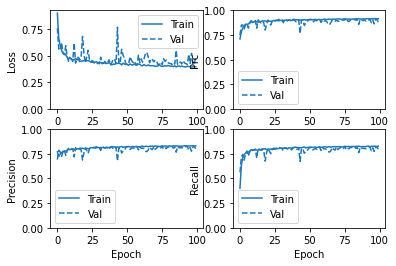

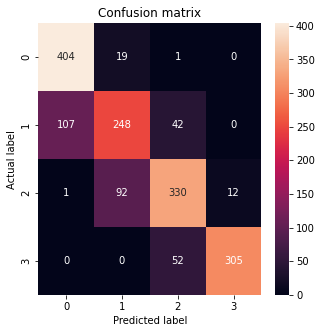

In [29]:
model = build_model(2, [30,20], 0.5, (17,), "relu", "adam", "categorical_crossentropy", METRICS, "softmax", 4)


model.summary()
h_100x4x100= model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test), batch_size=256)




train_predictions_baseline = model.predict(X_train, batch_size=256)
test_predictions_baseline = model.predict(X_test, batch_size=256)


plot_metrics(h_100x4x100)

baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=256, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(np.argmax(y_test.to_numpy(),axis=1), test_predictions_baseline.argmax(axis=1))

IGNORAR NLP CON TORCH

In [ ]:
cadenas

In [ ]:
datos = []
for x,y in zip(cadenas,cadenas_target):


    misdatos  = {}
    misdatos['label'] = y
    misdatos['text'] = x
    datos.append(misdatos)


In [ ]:
df = pd.DataFrame(data=np.reshape(cadenas,(-1,1)),columns=['text'])

In [ ]:
df['label'] = np.reshape(cadenas_target,(-1,1))

In [ ]:
from datasets import Dataset
ds = Dataset.from_pandas(df)
ds = ds.with_format('torch')
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

In [ ]:
ds = ds.map(preprocess_function, batched=True)


In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

In [ ]:
from datasets import load_metric
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
ds = ds.train_test_split(0.3)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds['train'],
    eval_dataset=ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()